## Red meat & colorectal cancer

Analysis of Relative Risks on colorectal cancer in association with red meat consumption. And also possible confounders and selection bias. Based on aggregated data from (NIH)-AARP
- Example of *confounding*: bias due to fruit intake
- Example of *selection bias*: differential loss to follow up due to coincidence of more than one cancer

### References:
- Cross AJ et al. (2007) A prospective study of red and processed meat intake in relation to cancer risk. PLoS Med
4(12): e325. doi:10.1371/journal


In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(65)


N = 294724+199312
def plot_chart2(my_y, n=np.array([N/5,N/5,N/5,N/5,N/5]), title='', truncate=False, grid=True, kind='red meat'):
    p = my_y/n
    myerr=1.96*np.sqrt(p*(1-p)/n)
  
    plt.errorbar(y=p,x=range(len(myerr)),yerr=[myerr,myerr], uplims=True, lolims=True)
    if not truncate:
        plt.ylim(0,1.3*(max(p)))
    plt.title('estimated proportion of cases per quintile of {} intake (CI 95% {})'.format(kind,title))
    if grid:
        plt.grid()

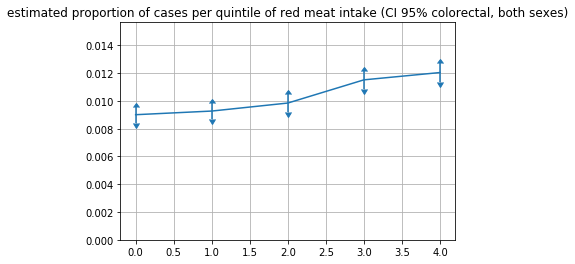

In [2]:
colorectal_cases_men=[472, 570, 674, 820, 935]
colorectal_cases_women=[418, 346, 299, 318, 255]
my_y = np.array(colorectal_cases_men)+np.array(colorectal_cases_women)
plot_chart2(my_y, title='colorectal, both sexes', grid=True)

Increase in Relative Risk due to red meat intake seems significant if we don't adjust on sex. In order to adjust on sex we need to estimate fraction of women and men at each quantile

In [3]:
prostate_cases = np.array([2777, 3117, 3588, 3803, 3950])
breast_cases = np.array([1485, 1351, 1292, 1006, 738])

only_women_cases = np.array(breast_cases)
only_men_cases = np.array(prostate_cases)

import numpy as np
def estimate_men_ratio(only_men_cases,only_women_cases):
    masculine = 1*only_men_cases/max(only_men_cases)
    feminine = only_women_cases/max(only_women_cases)
    pman=masculine/(masculine+feminine)
    return(pman)
    

def plot_ratio_estimates(pman):
    plt.plot(pman)
    plt.ylim([0,1])
    plt.title('Estimate ratio of male')
    plt.grid()
    return

def restimate_men_ratio_to_fit_total_number(pman):
    w_m=np.sum(pman*N/5)/294724
    pman = pman/w_m
    return pman


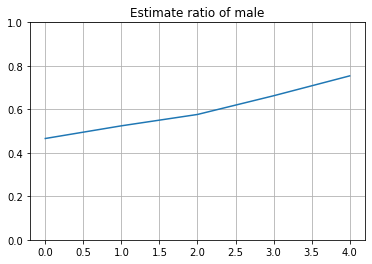

In [4]:
pman=estimate_men_ratio(only_men_cases,only_women_cases)
pman=restimate_men_ratio_to_fit_total_number(pman)
plot_ratio_estimates(pman)
pwoman = 1-pman

Minimum relative risk Q5 vs Q1 (CI 95%): 1.163


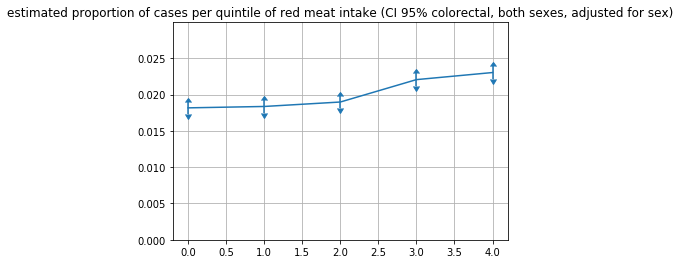

In [5]:
my_y = np.array((colorectal_cases_men/pman)+(colorectal_cases_women/(1-pman)))
plot_chart2(my_y,n=(N/5)*np.array([1,1,1,1,1]),title='colorectal, both sexes, adjusted for sex', grid=True)

def ratio_q5_to_q1(N,my_n):
    n=(N/5)*np.array([1,1,1,1,1])
    p = my_y/n
    myerr=1.96*np.sqrt(p*(1-p)/n)
    max_q0=p[0]+myerr[0]
    min_q5=p[4]-myerr[4]
    return(min_q5/max_q0)

relative_risk1 = ratio_q5_to_q1(N,my_y)
print("Minimum relative risk Q5 vs Q1 (CI 95%): {:.4}".format(relative_risk1))

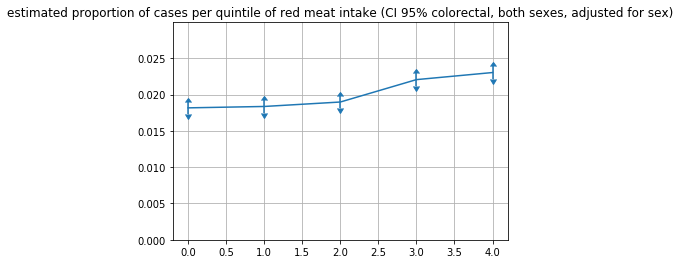

In [6]:
my_y = np.array(colorectal_cases_men/pman+colorectal_cases_women/pwoman)
plot_chart2(my_y, title='colorectal, both sexes, adjusted for sex', grid=True)

Restriction to men:

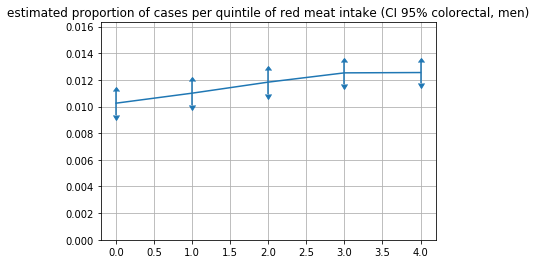

In [7]:
my_y = np.array(colorectal_cases_men)
plot_chart2(my_y,n=(N/5)*pman*np.array([1,1,1,1,1]), title='colorectal, men', grid=True)

Restriction to women:

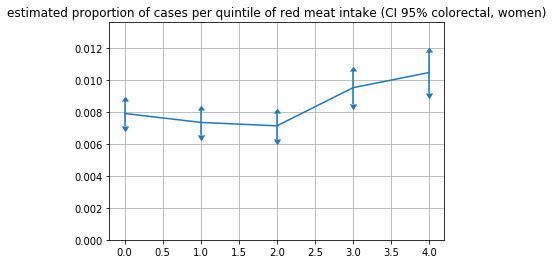

In [8]:
my_y = np.array(colorectal_cases_women)
plot_chart2(my_y,n=(N/5)*(1-pman)*np.array([1,1,1,1,1]), title='colorectal, women', grid=True)

### Analyze relation to fruits consumption

#### Guess distributions for red meat and fruit intake:
- For fruits intake: get my best guess for the relation to meat consumption

In [9]:
from sklearn.metrics import mean_absolute_error
def estimate_by_grid_search(myformula,mygoal):
    range_i=np.arange(0.1,10.0,0.05)
    range_j=np.arange(0.1,10.0,0.05)
    min_mae=float('inf')
    best_i_j = []
    for i in range_i:
        for j in range_j:
            myguess = eval(myformula)
            mae = mean_absolute_error(myguess,mygoal)
            if (mae < min_mae):
                min_mae = mae
                best_i_j = [i,j]
    return(best_i_j)

In [10]:
myformula2 = 'i/(np.power(np.array([12.0, 24.7, 35.1, 46.8, 67.0]), 1/j))'
mygoal=np.array([2.2,1.7,1.5,1.3,1.1])
(alpha_men,beta_men)=estimate_by_grid_search(myformula2,mygoal)
mygoal=np.array([2.6,2.2,1.9,1.6,1.4])
(alpha_women,beta_women)=estimate_by_grid_search(myformula2,mygoal)

- For meat intake: simulate with lognormal

In [11]:
import numpy as np
#np.random.seed(25)
np.random.seed(35)
Nsample=1000
myqi_sample = np.array([int(Nsample*i/10) for i in range(1,10,2)])
myformula1 = 'np.sort(np.random.lognormal(i,j,Nsample))[myqi_sample]'

mygoal=np.array([7.8,17.6,26.3,36.5,54.7])
(mu_women,sigma_women)=estimate_by_grid_search(myformula1,mygoal)

mygoal=np.array([12.0,24.7,35.1,46.8,67.0])
(mu_men,sigma_men)=estimate_by_grid_search(myformula1,mygoal)

#### Create a fake dataframe
- Masculine and feminine data:

In [12]:
import pandas as pd

Nmen=294724
Nwomen=199312
Ntotal = Nmen+Nwomen
colorectal_cases_men_redmeat=[472,570,674,820,935]
colorectal_cases_women_redmeat=[418,346,299,318,255]
all_cases_men_redmeat = [113+37+48+72+472+38+101+474+188+134+33+202+129+234+71+61+2777, 106+45+98+92+570+56+118+660+251+178+33+227+130+239+67+60+3117, 139+79+90+90+674+65+126+890+282+192+35+279+144+280+94+75+3588, 144+81+103+130+820+68+149+997+310+225+24+280+166+341+79+81+3803, 196+103+130+130+935+89+226+1280+372+267+48+277+188+315+80+92+3950]
all_cases_women_redmeat = [57+10+14+42+418+17+100+506+57+87+55+159+80+157+36+51+1485+333+149+29, 43+18+17+31+346+18+83+566+60+85+56+160+61+110+46+40+1351+274+131+21, 66+16+17+27+299+19+88+467+63+78+29+132+55+100+33+41+1292+236+92+27, 55+18+18+22+318+20+77+512+45+70+38+129+44+79+25+25+1006+204+110+16, 38+9+13+22+255+13+35+417+38+47+21+76+40+77+20+19+738+138+70+24]


def simulate_microdata_intakes(mu_men,sigma_men,Nmen):
    redmeat_intake_men = np.random.lognormal(mu_men,sigma_men,Nmen)
    fruit_intake_men=np.array([alpha_men/np.power(i,1/beta_men)+np.random.normal(0,0.05) for i in redmeat_intake_men])

    dfm = pd.DataFrame()
    dfm['redmeat']=np.sort(redmeat_intake_men)
    dfm['fruit']=fruit_intake_men[np.argsort(redmeat_intake_men)]
    return (dfm,redmeat_intake_men)

(dfm,redmeat_intake_men) = simulate_microdata_intakes(mu_men,sigma_men,Nmen)
(dfw,redmeat_intake_women) = simulate_microdata_intakes(mu_women,sigma_women,Nwomen)


In [13]:
# To simulate microdata we require the pgender, probability of man or woman at each quintile

def estimate_women_ratio(redmeat_intake_men,redmeat_intake_women,Ntotal):
    redmeat_intake = np.concatenate((redmeat_intake_men,redmeat_intake_women))
    q_th=np.array([int(np.round(Ntotal*i/5)) for i in range(0,6,1)])
    nwomen=[]
    for i in range(len(q_th)-1):
        nwomen.append(np.sum(np.argsort(redmeat_intake)[q_th[i]:q_th[i+1]]-Nmen>0))
    pwoman2=np.array(nwomen)*5/Ntotal
    return pwoman2
    
def simulate_microdata_cases(cases_gender,pgender):   
    my_y = np.array(cases_gender)
    n=(Ntotal/5)*pgender*np.array([1,1,1,1,1])
    p = my_y/n 
    return([np.random.binomial(1,p[i],size=int(np.round(n[i]))) for i in range(len(p))])

In [14]:
pwoman2=estimate_women_ratio(redmeat_intake_men,redmeat_intake_women,Ntotal)

def complete_dataframe_by_gender(dfm,colorectal_cases_men_redmeat,all_cases_men_redmeat,pwoman2, Nmen, gender):
    colorectal_men_microdata = np.concatenate(np.array(simulate_microdata_cases(np.array(colorectal_cases_men_redmeat),(1-pwoman2))))
    assert(len(colorectal_men_microdata)==Nmen)

    all_cases_men_redmeat = np.array(all_cases_men_redmeat)-np.array(colorectal_cases_men_redmeat)
    all_cases_men_microdata= np.concatenate(np.array(simulate_microdata_cases(np.array(all_cases_men_redmeat),(1-pwoman2))))

    dfm = dfm.copy()
    dfm=dfm.iloc[0:len(colorectal_men_microdata)]
    dfm.loc[:,'colorectal_cancer']=colorectal_men_microdata
    
    dfm.loc[:,'all_cancers_except_colorectal']=all_cases_men_microdata
    dfm.loc[:,'gender'] = gender
    return dfm
dfm=complete_dataframe_by_gender(dfm,colorectal_cases_men_redmeat,all_cases_men_redmeat,pwoman2, Nmen, 'M')
dfm.head()

,redmeat,fruit,colorectal_cancer,all_cancers_except_colorectal,gender
0,1.730860,4.621067,0,0,M
1,2.019067,4.278605,0,0,M
2,2.233136,4.283726,0,0,M
3,2.502208,4.065040,0,0,M
4,2.503076,4.029138,0,0,M


In [15]:
dfw=complete_dataframe_by_gender(dfw,colorectal_cases_women_redmeat,all_cases_women_redmeat,1-pwoman2, Nwomen-1, 'W')
dfw.head()

,redmeat,fruit,colorectal_cancer,all_cancers_except_colorectal,gender
0,1.247098,5.272802,0,0,W
1,1.482067,4.919591,0,0,W
2,1.581946,4.845297,0,0,W
3,1.714746,4.663668,1,0,W
4,1.755260,4.697803,0,0,W


- Concatenate masculine and feminine:

In [16]:
df = pd.concat((dfm,dfw))

### Recalculate relative risks based on fake synthetic dataframe
a) sort fake dataframe based on redmeat consumption

In [17]:
df = df.sort_values(by='redmeat').reset_index()
df.sample(10)

,index,redmeat,fruit,colorectal_cancer,all_cancers_except_colorectal,gender
28952,8734,10.716822,2.339726,0,1,M
379871,212148,46.954122,1.312760,0,0,M
170944,91433,22.920181,1.655155,0,0,W
187689,89210,24.284893,1.685742,0,0,M
325796,175641,38.262989,1.414154,0,0,M
36134,24641,11.529320,2.252046,0,0,W
336229,182510,39.702102,1.317956,0,1,M
473334,279075,87.541380,0.993277,0,0,M
141796,63223,20.610456,1.791444,0,0,M
262078,134436,30.993043,1.545336,0,0,M


In [18]:
myidx = np.array([(int(Ntotal*(i-1)/5),int(Ntotal*i/5)) for i in range(1,6)])
colorectal_cases_men_redmeat_syn = [df[(df.gender=='M') & (df.index>=i) & (df.index<j)].colorectal_cancer.sum() for (i,j) in myidx]
colorectal_cases_women_redmeat_syn = [df[(df.gender=='W') & (df.index>=i) & (df.index<j)].colorectal_cancer.sum() for (i,j) in myidx]

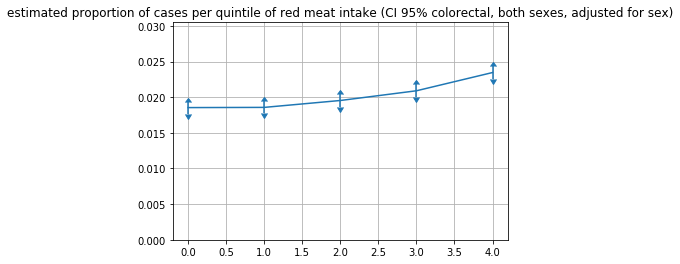

In [19]:
my_y = np.array((colorectal_cases_men_redmeat_syn/(1-pwoman2))+(colorectal_cases_women_redmeat_syn/(pwoman2)))
plot_chart2(my_y,n=(N/5)*np.array([1,1,1,1,1]),kind='red meat',title='colorectal, both sexes, adjusted for sex', grid=True)

In [20]:
relative_risk2 = ratio_q5_to_q1(N,my_y)
print("Minimum relative risk Q5 vs Q1 (CI 95%): {:.4}".format(relative_risk2))
assert(np.round(relative_risk2,2)==np.round(relative_risk1,2))

Minimum relative risk Q5 vs Q1 (CI 95%): 1.162


Include effect of those people loss to follow up due to more than one cancer. For this purpose:
- get ratio of colorectal cases of cancer from total cases in women and men
- get (fake) people with more than one cancer
- attribute fraction of hypothetical colorectal cancer according to previous steps

In [21]:
def get_ratio_of_colorectal_vs_total(gender):
    mymask=df['gender']==gender
    return df[mymask].colorectal_cancer.sum()/(df[mymask].all_cancers_except_colorectal.sum()+df[mymask].colorectal_cancer.sum())

ratio_colorectal_in_women=get_ratio_of_colorectal_vs_total('W')
ratio_colorectal_in_men=get_ratio_of_colorectal_vs_total('M')
print("Ratio of colorectal cancer vs total cases of cancer: {:.2} for women, {:.2} for men".format(ratio_colorectal_in_women, ratio_colorectal_in_men))

Ratio of colorectal cancer vs total cases of cancer: 0.11 for women, 0.099 for men


Minimum relative risk Q5 vs Q1 (CI 95%): 1.162


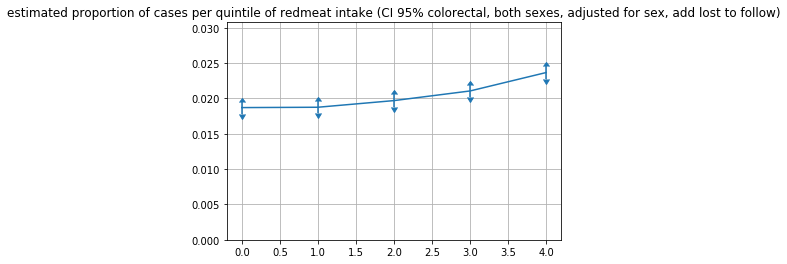

In [22]:
def guess_estimate_loss_to_follow(df):
    loss_to_follow_men_redmeat_syn = np.array([df[(df.gender=='M') & (df.index>=i) & (df.index<j) & (df.colorectal_cancer==1) & (df.all_cancers_except_colorectal==1)].count()[0] for (i,j) in myidx])   
    loss_to_follow_women_redmeat_syn = np.array([df[(df.gender=='W') & (df.index>=i) & (df.index<j) & (df.colorectal_cancer==1) & (df.all_cancers_except_colorectal==1)].count()[0] for (i,j) in myidx])
    loss_to_follow_men = np.round(ratio_colorectal_in_men*loss_to_follow_men_redmeat_syn)
    loss_to_follow_women = np.round(ratio_colorectal_in_women*loss_to_follow_women_redmeat_syn)
    return(loss_to_follow_men, loss_to_follow_women)

loss_to_follow_men_redmeat_syn,loss_to_follow_women_redmeat_syn=guess_estimate_loss_to_follow(df)
my_y = np.array(((colorectal_cases_men_redmeat_syn+loss_to_follow_men_redmeat_syn)/(1-pwoman2))+((colorectal_cases_women_redmeat_syn+loss_to_follow_women_redmeat_syn)/pwoman2))
plot_chart2(my_y, n=(N/5)*np.array([1,1,1,1,1]), kind='redmeat',title='colorectal, both sexes, adjusted for sex, add lost to follow', grid=True)
print("Minimum relative risk Q5 vs Q1 (CI 95%): {:.4}".format(ratio_q5_to_q1(N,my_y)))

b) Reorder dataframe based on fruits intake (reverse):

Minimum relative risk Q5 vs Q1 (CI 95%): 1.128


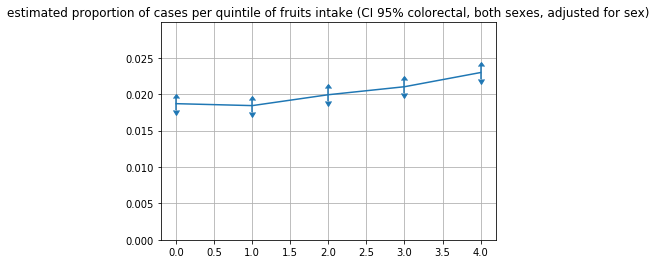

In [23]:
df=df.sort_values(by='fruit', ascending=False).reset_index()
colorectal_cases_men_fruit_syn = [df[(df.gender=='M') & (df.index>=i) & (df.index<j)].colorectal_cancer.sum() for (i,j) in myidx]
colorectal_cases_women_fruit_syn = [df[(df.gender=='W') & (df.index>=i) & (df.index<j)].colorectal_cancer.sum() for (i,j) in myidx]

my_y = np.array((colorectal_cases_men_fruit_syn/(1-pwoman2))+(colorectal_cases_women_fruit_syn/(pwoman2)))
plot_chart2(my_y,n=(N/5)*np.array([1,1,1,1,1]),kind='fruits',title='colorectal, both sexes, adjusted for sex', grid=True)
print("Minimum relative risk Q5 vs Q1 (CI 95%): {:.4}".format(ratio_q5_to_q1(N,my_y)))

Minimum relative risk Q5 vs Q1 (CI 95%): 1.126


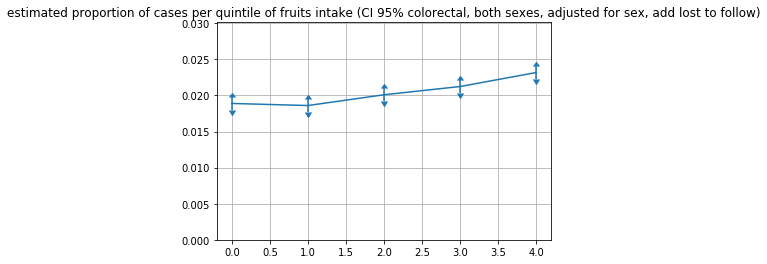

In [24]:
loss_to_follow_men_fruit_syn,loss_to_follow_women_fruit_syn=guess_estimate_loss_to_follow(df)

my_y = np.array(((colorectal_cases_men_fruit_syn+loss_to_follow_men_fruit_syn)/(1-pwoman2))+((colorectal_cases_women_fruit_syn+loss_to_follow_women_fruit_syn)/pwoman2))
plot_chart2(my_y, n=(N/5)*np.array([1,1,1,1,1]), kind='fruits',title='colorectal, both sexes, adjusted for sex, add lost to follow', grid=True)
print("Minimum relative risk Q5 vs Q1 (CI 95%): {:.4}".format(ratio_q5_to_q1(N,my_y)))